# CFFI, Ctypes, Cython, Cppyy: 
# Wrapping C code from Python


## Matti Picus

### Follow along at https://github.com/mattip/c_from_python

## Who am I?

- Core PyPy developer (ask me later)
- Working on NumPy 2018 - 2020
- Experienced (old?) programmer, been doing image processing on and off since 1980
- Open Source evangelist

## Thanks for tuning in.

Here is what we will do

<p></p>
<details>
<summary>The ``mandelbrot`` fractal image</summary>  
  
  - Pure Python  
  - Pure C  
  - Measure speed of execution
</details>  
<p></p>
<details>
<summary>How to mix C and Python</summary>  
  - Ctypes  
  - CFFI
  - Cython
  - Cppyy
</details>  
<p></p>
<details>
<summary>Comparison</summary>  
  - Boilerplate  
  - Maintenance  
  - Speed
</details>
<p></p>
A pop quiz
<p></p>
Questions

In [1]:
# Ignore the man behind the curtain
from __future__ import print_function, division
%matplotlib notebook
from timeit import default_timer as timer
import numpy as np
from PIL import Image
import subprocess
import os, sys
import numpy as np
from matplotlib.pylab import imshow, show, figure, subplots, get_cmap

## Our mission

Create a fractal image. Hmm, what is an image? We decide to define a simple structure to hold the image: width, height, data-as-pointer

In [2]:
class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = bytearray(width*height)

width = 1500
height = 1000
image = Img(width, height)

OK, how do we make a fractal image? We loop over the image, doing a calculation at each pixel location $x$, $y$.
For reasons known to only a select few, we normalize the horizontal $x$ values to be from -2 to 1 and the vertical $y$ values to -1 to 1, and then call a function [`mandel`](https://en.wikipedia.org/wiki/Mandelbrot_set) with these normalized values. $x$, $y$ will become the real, imaginary parts of a complex number and we will do some math on that value. 

Also, our system architect (geez I don't like him) is adamant that every function return a status, so our calculation function must accept a pointer to the value to be returned. This makes more sense in C, but can be done in python as well, although awkwardly.

Since each framework has a different idea on what it means to create this pointer, we pass it in to our outer function (the one that will loop over all the pixels and calculate the actual pixel value. Now we can re-use the function in each of the frameworks more easily. At least the system architect agreed to that!

## The looping function

These links are placeholders for later use  
[as used in ctypes](#Ctypes-use)  
[as used in CFFI](#CFFI-use)  
[as used in Cython](#Cython-use)  
[as used in Cppyy](#Cppyy-use)  


In [3]:
def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            
            ret = func(real, imag, iters, oneval) # <---- HERE is the real work
            if ret < 0:
                return ret
            image.data[yy + x] = oneval[0]
    return 0

In [4]:
# This is the calculating function in python

def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

In [5]:
# OK, lets try it out. Here is our pure python fractal generator

oneval = bytearray(1)  # this is a kind of pointer in pure python
s = timer()
ret = create_fractal(image, 20, mandel, oneval)
e = timer()
if ret < 0:
    print('bad ret value from creat_fractal')
pure_python = e - s
print('pure python required {:.2f} secs'.format(pure_python))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('python_numpy.png')

pure python required 5.36 secs


<IPython.core.display.Javascript object>


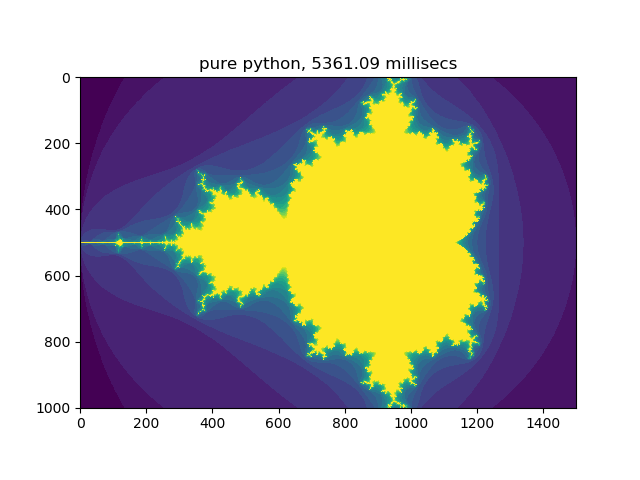

In [6]:
fig, ax = subplots(1)
img = Image.open('python_numpy.png')
in_data = np.asarray(im, dtype=np.uint8)
#ax.plot(img.histogram())
ax.imshow(in_data) 
ax.set_title('pure python, {:.2f} millisecs'.format(pure_python*1000));

EVERYONE KNOWS PYTHON IS TOO SLOW! So we outsource the whole thing to a 
contractor, keeping the format of two functions and their signatures. 

The contractor rewrites it in C. Budgeted for one month, contracted for two, 
we got the code after 4 months, with no tests. Who writes these contracts? We now have our `mandel` function in C99 compliant C using the `_Complex` struct.


Now the ``*val`` design make sense

In [7]:
# print out the file "mandel.c"
with open('mandel.c', 'rt') as fid:
    print(fid.read())

#include "create_fractal.h"
int mandel(float x, float y, int max_iters, unsigned char * val)
{
    int i = 0;
    float cR = x;
    float cI = y;
    float zR = 0;
    float zI = 0;
    for (i = 0; i < max_iters; i++)
    {
        /* in complex notation, z * z + c */
	float prev_zR = zR;
        zR = zR * zR - zI * zI + cR;
        zI = 2 * prev_zR * zI + cI;
        if ((zR * zR + zI * zI) >= 4)
        {
            *val = i;
            return 0;
        }
    }
    *val = max_iters;
    return 1;
}



Hang on, what's this? Hah! The contractor may not have a full validation suite but at least they wrote a test runner file `create_fractal.c`

In [8]:
# print out "create_fractal.c"
with open('create_fractal.c', 'rt') as fid:
    print(fid.read())

#include "create_fractal.h"

int create_fractal(Img img,  int iters) {
    float pixel_size_x = 3.0 / img.width;
    float pixel_size_y = 2.0 / img.height;
    int x, y, ret=0;
    for (y=0; y < img.height; y++) {
        float imag = y * pixel_size_y - 1;
        int yy = y * img.width;
        for (x=0; x < img.width; x++) {
            float real = x * pixel_size_x - 2;
            unsigned char color;
            ret += mandel(real, imag, iters, &color);
            img.data[yy + x] = color;
        }
    }
    return ret;
}



In [16]:
# We will compile the functions into a shared object
# and time the call to create_fractal, as before
with open('main.c', 'rt') as fid:
    print(fid.read())

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include "create_fractal.h"

#ifdef CLOCK_PROCESS_CPUTIME_ID
// call this function to start a nanosecond-resolution timer
struct timespec timer_start(){
    struct timespec start_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &start_time);
    return start_time;
}

// call this function to end a timer, returning nanoseconds elapsed as a long
long timer_end(struct timespec start_time){
    struct timespec end_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &end_time);
    long diffInNanos = end_time.tv_nsec - start_time.tv_nsec;
    return diffInNanos;
}
#else
#include <sys\timeb.h> 
#endif

int main(int argc, const char *argv[], const char * env[])
{
    int width = 1500;
    int height = 1000;
    int iters = 20;
    FILE * fid = NULL;
    Img img;
    size_t written;
#ifdef CLOCK_PROCESS_CPUTIME_ID
    struct timespec vartime;
#else
    struct timeb start, stop;
#endif
    long time_elapsed_nanos;
    img.width = width;
  

In [18]:
# Compile a shared object, and then compile the exe. If you are following along in Windows, well, good luck.
if sys.platform == 'win32':
    subprocess.check_call(['cl', '/LD', 'mandel.c', 'create_fractal.c', '-Fecreate_fractal.dll'])
    subprocess.check_call(['cl', 'main.c', 'create_fractal.lib', '-Femain.exe'])
else:
    subprocess.check_call(['gcc', '--shared', '-fPIC', '-O3', 'mandel.c', 'create_fractal.c', 
                         '-olibcreate_fractal.so'])
    subprocess.check_call(['gcc', '-O3', 'main.c', '-L.', '-lcreate_fractal', '-omain']);

In [19]:
environ = os.environ.copy()
environ['LD_LIBRARY_PATH'] = environ.get('LD_LIBRARY_PATH', '') + ':.'
if sys.platform == 'win32':
    exe = 'main.exe'
else:
    exe = './main'
p = subprocess.Popen([exe,], stdout=subprocess.PIPE, stderr=subprocess.PIPE, env=environ)
stdout, stderr = p.communicate()
stdout = str(stdout)
print(stdout)
pure_c = int(stdout.split(' ')[2])
print('Pure python is {:.1f} times slower than pure C'.format(1000.0*pure_python/pure_c));

b'create_fractal required 82 millisecs\r\n'
Pure python is 65.4 times slower than pure C


<IPython.core.display.Javascript object>


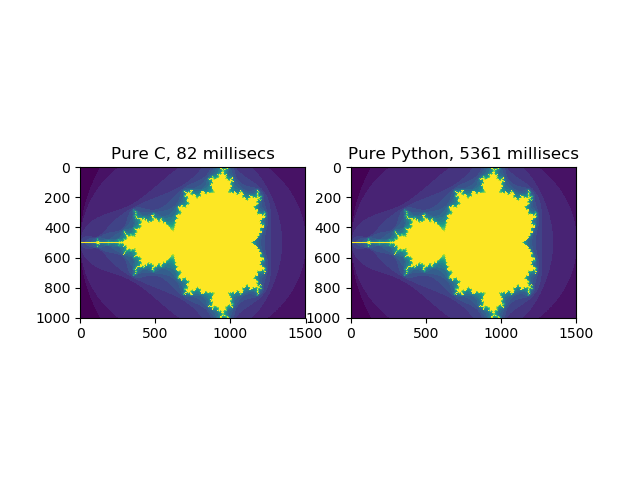

In [20]:
from matplotlib.pylab import imshow, show, figure, subplots
fig, ax = subplots(1,2)
with open('c.raw', 'rb') as fid:
    img = Image.frombytes(data=fid.read(), size=(1500,1000), mode="L")
ax[0].imshow(np.asarray(img, dtype='uint8'))
ax[0].set_title('Pure C, {:d} millisecs'.format(pure_c))

img = Image.open('python_numpy.png')
ax[1].imshow(np.asarray(img, dtype='uint8'))
ax[1].set_title('Pure Python, {:.0f} millisecs'.format(1000*pure_python));

Cool. We now have  a version in pure C that runs in under 200 ms. 

But hang on, we wanted this to be part of a whole pipeline, where we can use and reuse the functions ``mandel`` and ``create_fractal``. 

Note that we compiled ``libcreate_fractal.so`` which wraps our fast C function as a shared object, so maybe we can call it from Python?

We have heard of four methods to interface C with Python: ctypes, CFFI, Cython, Cppyy. Let's try them out.

In [60]:
# We will need this to tell the various systems where to find things
if sys.maxsize < 2 ** 33:
    arch = '32'
else:
    arch = '64'
if sys.platform == 'win32':
    dllname = './create_fractal%s.dll' % arch
    libname = 'create_fractal%s' % arch
else:
    dllname = './libcreate_fractal.so'
    libname = 'create_fractal'

In [29]:
#ctypes
# First all the declarations. Each function and struct must be redefined ...
import ctypes

class CtypesImg(ctypes.Structure):
    _fields_ = [('width', ctypes.c_int),
                ('height', ctypes.c_int),
                ('data', ctypes.POINTER(ctypes.c_uint8)), # HUH?
               ]
    array_cache = {}
    def __init__(self, width, height):
        self.width = width
        self.height = height
        # Create a class type to hold the data.
        # Since this creates a type, cache it for reuse rather
        # than create a new one each time
        if width*height not in self.array_cache:
            self.array_cache[width*height] = ctypes.c_uint8 * (width * height)
        # Note this keeps the img.data alive in the interpreter
        self.data = self.array_cache[width*height]() # !!!!!!

    def asmemoryview(self):
        # There must be a better way, but this code will not
        # be timed, so explicit trumps implicit
        ret = self.array_cache[self.width*self.height]()
        for i in range(self.width * self.height):
            ret[i] = self.data[i]
        return memoryview(ret)

ctypesimg = CtypesImg(width, height)

    
# Load the shared object (DLL in Windows)
cdll = ctypes.cdll.LoadLibrary(dllname)

#Fish the function pointers from the shared object and define the interfaces
create_fractal_ctypes = cdll.create_fractal
create_fractal_ctypes.argtypes = [CtypesImg, ctypes.c_int]

mandel_ctypes = cdll.mandel
mandel_ctypes.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_int, 
                          ctypes.POINTER(ctypes.c_uint8)]

In [30]:
# We have "typed" the function, it knows what to expect, so this should error
try:
    create_fractal_ctypes()
except TypeError as e:
    print(str(e))

this function takes at least 2 arguments (0 given)


### Ctypes use

Let's run this, twice. Once to call the C implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [31]:
s = timer()
create_fractal_ctypes(ctypesimg, 20)
e = timer()
ctypes_onecall = e - s
print('ctypes calling create_fractal required {:.2f} millisecs'.format(1000*ctypes_onecall))
im = Image.frombuffer("L", (width, height), ctypesimg.asmemoryview(), 'raw', 'L', 0, 1)
im.save('ctypes_fractal.png')

value = (ctypes.c_uint8*1)()
s = timer()
create_fractal(ctypesimg, 20, mandel_ctypes, value)
e = timer()
ctypes_mandel = e - s
print('ctypes calling mandel required {:.2f} millisecs'.format(1000*ctypes_mandel))
im = Image.frombuffer("L", (width, height), ctypesimg.asmemoryview(), 'raw', 'L', 0, 1)
im.save('ctypes_mandel.png')

ctypes calling create_fractal required 144.21 millisecs
ctypes calling mandel required 2198.44 millisecs


<IPython.core.display.Javascript object>


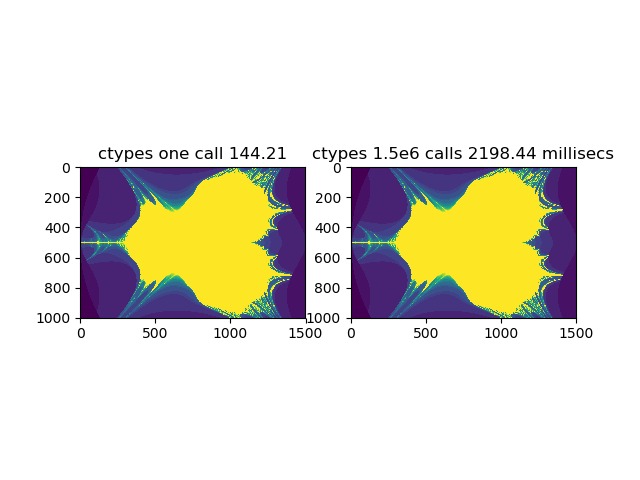

In [32]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('ctypes_fractal.png')
ctypes2 = Image.open('ctypes_mandel.png')
ax[0].imshow(np.asarray(ctypes1, dtype='uint8'))
ax[0].set_title('ctypes one call {:.2f}'.format(1000 * ctypes_onecall))

ax[1].imshow(np.asarray(ctypes2, dtype='uint8'))
ax[1].set_title('ctypes 1.5e6 calls {:.2f} millisecs'.format(1000*ctypes_mandel));

In [44]:
#cffi - ABI mode (like ctypes)
import cffi
ffi = cffi.FFI()
# Two stages, cdef reads the headers, then dlopen finds the functions in the shared object

with open('create_fractal.h', 'rt') as fid:
    cleaned = []
    # clean up all preprocessor macros before calling this
    print('Contents of create_fractal.h\n------------\n')
    for line in fid:
        print(line[:-1])
        if line[0] == '#' or 'EXPORT' in line:
            continue
        cleaned.append(line[:-1])
    print('\n---------------------\n')
    print('Contents of cleaned up header\n-----------------\n')
    print('\n'.join(cleaned))
ffi.cdef('\n'.join(cleaned))

dll = ffi.dlopen(dllname)

Contents of create_fractal.h
------------

typedef struct _Img{
    int width;
    int height;
    unsigned char * data;
} Img;


#ifdef _MSC_VER
#define EXPORT __declspec( dllexport )
#else
#define EXPORT
#endif
EXPORT
int create_fractal(Img img, int iters);
EXPORT
int mandel(float real, float imag, int max_iters, unsigned char * val);


---------------------

Contents of cleaned up header
-----------------

typedef struct _Img{
    int width;
    int height;
    unsigned char * data;
} Img;


int create_fractal(Img img, int iters);
int mandel(float real, float imag, int max_iters, unsigned char * val);



### CFFI use

Let's run this, twice. Once to call the C implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [45]:
# Initializing an image looks just like C. Note two things:
# - ffi has state, that is the point of creating an ffi object
# - img is a "pointer", so we use img[0] to dereference it
img = ffi.new('Img[1]')
img[0].width = width
img[0].height = height
#img[0].data = ffi.new('unsigned char[%d]' % (width*height,)) # NO NO NO NO
# This is C - we must keep the pointer alive !!!
data1 = ffi.new('unsigned char[%d]' % (width*height,))
img[0].data = data1

s = timer()
dll.create_fractal(img[0], 20)
e = timer()
cffi_onecall = e - s
print('cffi calling create_fractal required {:.2f} millisecs'.format(1000 * cffi_onecall))
m = Image.frombuffer('L', (width, height), ffi.buffer(data1), 'raw', 'L', 0, 1)
im.save('cffi_fractal.png')

data2 = ffi.new('unsigned char[%d]' % (width*height,))
img[0].data = data2
value = ffi.new('unsigned char[1]')
s = timer()
create_fractal(img[0], 20, dll.mandel, value)
e = timer()
cffi1_mandel = e - s
print('cffi calling mandel required {:.2f} millisecs'.format(1000*cffi1_mandel))
im = Image.frombuffer('L', (width, height), ffi.buffer(data2), 'raw', 'L', 0, 1)
im.save('cffi_mandel.png')

cffi calling create_fractal required 139.34 millisecs
cffi calling mandel required 925.74 millisecs


<IPython.core.display.Javascript object>


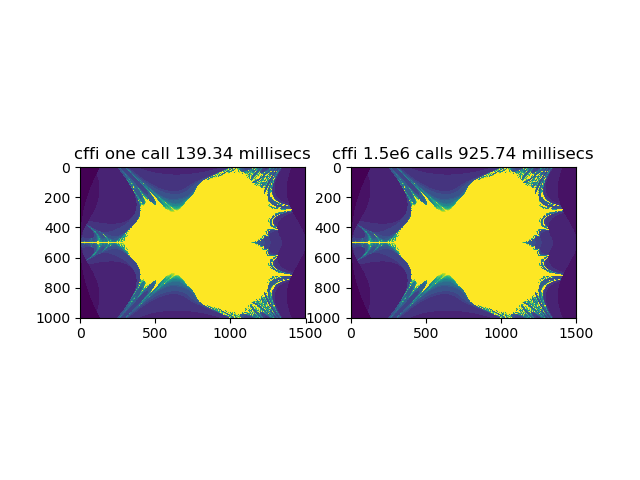

In [46]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cffi_fractal.png')
ctypes2 = Image.open('cffi_mandel.png')
ax[0].imshow(np.asarray(ctypes1, dtype='uint8'))
ax[0].set_title('cffi one call {:.2f} millisecs'.format(1000*cffi_onecall))

ax[1].imshow(np.asarray(ctypes2, dtype='uint8'))
ax[1].set_title('cffi 1.5e6 calls {:.2f} millisecs'.format(1000*cffi1_mandel));

That was ABI mode (ctypes). Can we do better?
Cffi has four [modes](https://cffi.readthedocs.io/en/latest/overview.html#other-cffi-modes), based on whether or not the code is compiled, and whether the resulting module can be imported or `dlopen`ed

In [51]:
#cffi - API mode (like cython)
import cffi
ffiAPI = cffi.FFI()
# Two stages, cdef reads the headers, then compile builds the module

with open('mandel.c', 'rt') as fid:
    code = fid.read()
with open('create_fractal.c', 'rt') as fid:
    code += fid.read()
    
ffiAPI.cdef('\n'.join(cleaned))
ffiAPI.set_source('cffiAPI', code)
ffiAPI.compile(verbose=True)

generating .\cffiAPI.c
(already up-to-date)
the current directory is 'c:\\pypy_stuff\\c_from_python'
running build_ext
building 'cffiAPI' extension
C:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.14.26428\bin\HostX86\x86\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -Ic:\pypy_stuff\Anaconda3_v5.2\include -Ic:\pypy_stuff\Anaconda3_v5.2\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.14.26428\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\shared" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\um" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\winrt" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\cppwinrt" "-IC:\Program Files (x86)\Microsoft Visual Studio\2017\BuildTools\VC\Tools\MSVC\14.14.26428\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.17763.0\ucrt" "-IC:

'c:\\pypy_stuff\\c_from_python\\cffiAPI.cp36-win32.pyd'

In [52]:
import cffiAPI

img = cffiAPI.ffi.new('Img[1]')
img[0].width = width
img[0].height = height
#img[0].data = ffi.new('unsigned char[%d]' % (width*height,)) # NO NO NO NO
# This is C - we must keep the pointer alive !!!
data1 = cffiAPI.ffi.new('unsigned char[%d]' % (width*height,))
img[0].data = data1

s = timer()
cffiAPI.lib.create_fractal(img[0], 20)
e = timer()
cffiAPI_onecall = e - s
print('cffi calling create_fractal required {:.2f} millisecs'.format(1000 * cffiAPI_onecall))
m = Image.frombuffer('L', (width, height), ffi.buffer(data1), 'raw', 'L', 0, 1)
im.save('cffiAPI_fractal.png')

data2 = cffiAPI.ffi.new('unsigned char[%d]' % (width*height,))
img[0].data = data2
value = cffiAPI.ffi.new('unsigned char[1]')

s = timer()
create_fractal(img[0], 20, cffiAPI.lib.mandel, value)
e = timer()
cffiAPI_mandel = e - s
print('cffi calling mandel required {:.2f} millisecs'.format(1000*cffiAPI_mandel))
im = Image.frombuffer('L', (width, height), ffi.buffer(data2), 'raw', 'L', 0, 1)
im.save('cffi_mandel.png')

cffi calling create_fractal required 38.27 millisecs
cffi calling mandel required 718.42 millisecs


In [53]:
%load_ext Cython

Hang on, isn't Cython used for compiling python to C? 

Well, yes, but, in this case we already have C code from our contractor...
So we can use Cython to call our already compiled C quickly. This allows us to compare apples to apples. We will also see how to use python in cyton later on

In [61]:
%%cython -a -I. -L. -l $libname --link-args=-Wl,-rpath=.

cdef extern from 'create_fractal.h':
    ctypedef struct Img:
        int width
        int height
        unsigned char * data
    
    int create_fractal(Img img, int iters);
    int mandel(float real, float imag, int max_iters,
               unsigned char * val);
    
def cython_create_fractal(pyimg, iters):
    cdef Img cimg
    cdef int citers
    cdef unsigned char[::1] tmp = pyimg.data
    
    citers = iters
    cimg.width = pyimg.width
    cimg.height = pyimg.height
    cimg.data = &tmp[0]
    return create_fractal(cimg, citers)


cpdef int cython_mandel(float real, float imag, int max_iters,
                        unsigned char[::1] val):
    return mandel(real, imag, max_iters, &val[0])

### Cython use

Let's run this, twice. Once to call the C implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [62]:
# use it, remember we have "image" from the pure python version 

s = timer()
cython_create_fractal(image, 20)
e = timer()
cython_onecall = e - s
print('cython onecall required {:.2f} millisecs'.format(1000*cython_onecall))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cython_fractal.png')

value = bytearray(1)
s = timer()
create_fractal(image, 20, cython_mandel, value)
e = timer()
cython1_mandel = e - s
print('cython many calls required {:.2f} millisecs'.format(1000*cython1_mandel))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cython_mandel.png')

cython onecall required 137.41 millisecs
cython many calls required 916.12 millisecs


<IPython.core.display.Javascript object>


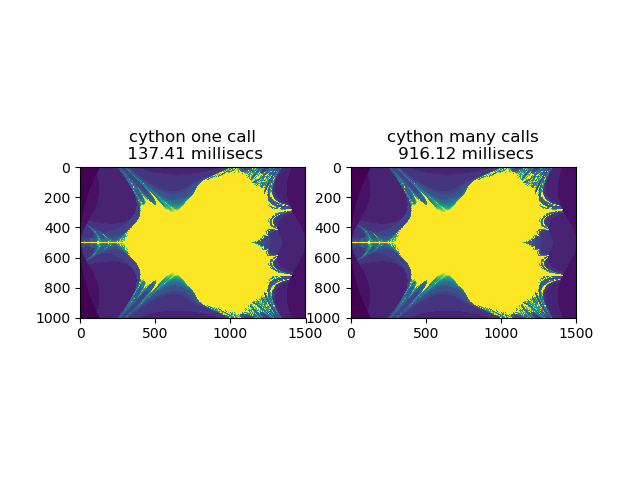

In [63]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cython_fractal.png')
ctypes2 = Image.open('cython_mandel.png')
ax[0].imshow(np.asarray(ctypes1, dtype='uint8'))
ax[0].set_title('cython one call\n {:.2f} millisecs'.format(1000*cython_onecall))
ax[1].imshow(np.asarray(ctypes2, dtype='uint8'))
ax[1].set_title('cython many calls\n {:.2f} millisecs'.format(1000*cython1_mandel))
fig.show()

In [64]:
%%cython -a -f
#cythonize the python code
def cython_mandel2(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    cdef int i = 0
    cdef complex c = complex(x,y)
    cdef complex z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

In [65]:
s = timer()
create_fractal(image, 20, cython_mandel2, value)
e = timer()
cython2_mandel = e - s
print('cython many calls required {:.2f} millisecs'.format(1000*cython2_mandel))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cython_mandel.png')

cython many calls required 669.64 millisecs


### What happened?

Is this faster than using C?

# CPPYY

Cppyy is a run-time bindings generator for C++ that works on both CPython and PyPy. It requirese VS2019 and up on windows.
It is vastly overkill for calling into simple C code as in this example,
but if the vendor provided you with a complex C++ API, especially one that uses
templates and modern C++ features, it will handle that, too, with ease.

To install cppyy, run 'pip install cppyy'. As it uses a custom version of LLVM,
it needs to install a binary package that wraps LLVM. One is available already on Linux and Mac OS but for Windows this needs to compile LLVM from source. Once built, the package
will be cached as a binary wheel, and installation will be fast.

In [66]:
import cppyy

# The following assumes that the shared library has already been created (e.g.
# for the cffi example above); otherwise cppyy can compile the C code on-the-fly,
# using cppdef() as in the example below.
cppyy.c_include("create_fractal.h")
cppyy.load_library(dllname)

# For convenience, create a C++ class from the C struct to manage the memory.
# Alternatively, assign a Python array from module array or a NumPy array (the
# C++ side will get a non-owning view on assignment.)
if not hasattr(cppyy.gbl, 'cppImg'):
    cppyy.cppdef("""
    struct cppImg : public Img {
        cppImg(int w, int h) : Img{w, h, new unsigned char[w*h]} {}
        ~cppImg() { delete [] data; }
        cppImg(const cppImg&) = delete;
        cppImg& operator=(const cppImg&) = delete;
    };""")


(Re-)building pre-compiled headers (options: -O2); this may take a minute ...


c:\pypy_stuff\Anaconda3_v5.2\lib\site-packages\cppyy_backend\loader.py:111: UserWarning: No precompiled header available (failed to build); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)


AttributeError: 'TInterpreter' object has no attribute 'AddIncludePath'

### Cppyy use

Let's run this, twice. Once to call the C implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [ ]:
cppyy_image = cppyy.gbl.cppImg(width, height)

s = timer()
ret = cppyy.gbl.create_fractal(cppyy_image, 20)
e = timer()
if ret < 0:
    print('bad ret value from create_fractal')
cppyy_onecall = e - s
print('cppyy calling create_fractal required {:.2f} millisecs'.format(1000*cppyy_onecall))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cppyy_fractal.png')


def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    image_data = image.data   # performance hack (not needed on PyPy)
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            ret = func(real, imag, iters, oneval) # <---- HERE is the real work
            if ret < 0:
                return ret
            image_data[yy + x] = oneval[0]
    return sum

s = timer()
oneval = bytearray(1)
create_fractal(cppyy_image, 20, cppyy.gbl.mandel, oneval)
e = timer()
cppyy_mandel = e - s
print('cppyy many calls required {:.2f} millisecs'.format(1000*cppyy_mandel))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cppyy_mandel.png')

In [ ]:
fig, ax = subplots(1,2)
cppyy1 = Image.open('cppyy_fractal.png')
cppyy2 = Image.open('cppyy_mandel.png')
ax[0].imshow(np.asarray(cppyy1, dtype='uint8'))
ax[0].set_title('cppyy one call\n {:.2f} millisecs'.format(1000*cppyy_onecall))

ax[1].imshow(np.asarray(cppyy2, dtype='uint8'))
ax[1].set_title('cppyy many calls\n {:.2f} millisecs'.format(1000*cppyy_mandel))
fig.show()

Now let's try and work out who is the good, who the bad

In [67]:
import pandas as pd
data = [
 ['Python',          '{:13.2f} millisecs'.format(1000*pure_python), ''],
 ['C     ',          '', '{:8.2f} millisecs'.format(pure_c)],
 ['ctypes',          '{:13.2f}'.format(1000*ctypes_mandel), '{:8.2f}'.format(1000*ctypes_onecall)],
 ['cffi - ABI',      '{:13.2f}'.format(1000*cffi1_mandel), '{:8.2f}'.format(1000*cffi_onecall)],
 ['cffi - API',      '{:13.2f}'.format(1000*cffiAPI_mandel), '{:8.2f}'.format(1000*cffiAPI_onecall)],
 ['cython - c',      '{:13.2f}'.format(1000*cython1_mandel), '{:8.2f}'.format(1000*cython_onecall)],
 ['cython - python', '{:13.2f}'.format(1000*cython2_mandel), '{:8.2f}'.format(1000*cython_onecall)],
 #['cppyy ',          '{:13.2f}'.format(1000*cppyy_mandel), '{:8.2f}'.format(1000*cppyy_onecall)],
    
]
pd.DataFrame(data, columns=['time in ms', 'CreateFractal in Python', 'CreateFractal in C'])

,time in ms,CreateFractal in Python,CreateFractal in C
0,Python,5361.09 millisecs,
1,C,,82.00 millisecs
2,ctypes,2198.44,144.21
3,cffi - ABI,925.74,139.34
4,cffi - API,718.42,38.27
5,cython - c,916.12,137.41
6,cython - python,669.64,137.41


Things to think about, besides speed:

* Maintainability
  - What happens when the C code changes?
* Compiler dependency
  - ctypes needs none, Cython requires one, CFFI can go either way
  - cppyy includes the LLVM backend (which is why it is ~50 MB)
* Susceptibility to bugs (object lifetimes, signature mismatches)
  - All use a minilanguage for interfacing, only CFFI's is standard C
  - Cython will handle most transformations automatically
  - CFFI can be tricky for C-level pointers
  - Cppyy is young but leverages LLVM
* Speed and productivity
  - Cython is heavily optimized, tightly integrated to the Python C-API
  - If the headers are pure C, CFFI should be simple
  - Projects exist to generate wrappers
* Which technology is actively maintained (ctypes went into the stdlib to die)?

 ---  
 ---  
 ---  
 ---  
    




And now the pop quiz. If we run the pure python version in PyPy what time will we get?:

* Around a 2X speed up compared to CPython
* About like Cython or CFFI calling mandel 1.5e6 times
* About like C compiled -O3

In [68]:
%%script pypy
from __future__ import print_function, division
import sys
print(sys.executable)
print(sys.version)
from timeit import default_timer as timer

from PIL import Image


class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = bytearray(width*height)

def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, oneval)
            image.data[yy + x] = oneval[0]

def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

# Pure python
width = 1500
height = 1000
image = Img(width, height)
s = timer()
oneval = bytearray(1)
create_fractal(image, 20, mandel, oneval) # < --- HERE IS THE CALL
e = timer()
pure_pypy = e - s
print('pure pypy required {:.2f} millisecs'.format(1000*pure_pypy))
im = Image.frombuffer('L', (1500, 1000), image.data, 'raw', 'L', 0, 1)
im.save('pypyy.png')

Couldn't find program: 'pypy'


In [ ]:
fig, ax = subplots(1)
ctypes1 = Image.open('pypyy.png')
ax.imshow(np.asarray(ctypes1, dtype='uint8'))
ax.set_title('pure pypy');